In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Lambda, Flatten
from tensorflow.keras import Model
from tensorflow.keras.layers import concatenate
from tensorflow.keras.utils import plot_model

import ot  
import ot.plot
%matplotlib inline

In C:\Users\manyasha_n_m\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\manyasha_n_m\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\manyasha_n_m\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\manyasha_n_m\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\manyasha_n_m\Anaconda3\lib\site-packages\matplotlib\

In [2]:
from mitdeeplearning import util
import os
import time
import functools
from IPython import display as ipythondisplay
from IPython.display import clear_output
from tqdm import tqdm

In [3]:
def discrete_gaussian(mean, variance, interval): 
    f = np.exp(-(interval-mean)**2/(2*variance)) / np.sqrt(2*np.pi*variance)
    return f/f.sum()

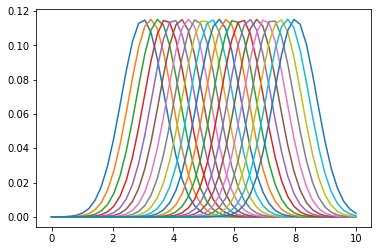

In [4]:
# experimental distriputions
interval = np.linspace(0, 10, 50, dtype='float32')

A = discrete_gaussian(7, 0.5, interval)
B = discrete_gaussian(3, 0.5, interval)
C = discrete_gaussian(5, 0.5, interval)
D = discrete_gaussian(8, 0.5, interval)
MU = [discrete_gaussian(i, 0.5, interval) for i in np.linspace(3, 8, 21)]

plt.figure()
for m in MU:
    plt.plot(interval, m)


In [5]:
# test cost functions
c_f1 = lambda x,y: (x-y)**2  # distance squared
c_f2 = lambda x, y: 1/(1+np.abs(x-y)) # coulomb cost

def construct_tensor(x, n_marginals, func): #creates cost tensor from a base function
    X = []
    C = 0
    for i in range(n_marginals):
        shape = [1]*n_marginals
        shape[i] = len(x)
        X.append(np.reshape(x, tuple(shape)))
        
    for i in range(n_marginals-1):
        for j in range(i+1, n_marginals):
            C = C+func(X[i], X[j])
            
    return C

# test Cost tensors for different number of marginals
C1 = [construct_tensor(interval, n, c_f1) for n in range(2, 6)]
C2 = [construct_tensor(interval, n, c_f2) for n in range(2, 6)]

In [6]:
# Neural nerwork architecture
class OT_network:
    def __init__(self, C, eps):
        self.C = C
        self.eps = eps
        self.K = np.exp(-C/C.max()/eps)
        self.n_marginals = len(C.shape)
        self.shapes = (self.n_marginals, C.shape[0], )
        
        self.model = self.build_model()
        self.optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01)
    
    def build_model(self): #model via functional api 
        input_msrs = [Input(shape=self.shapes[1], name=f"M{i+1}") for i in range(self.n_marginals)] # takes array of marginal measures
        concat_msrs = concatenate(input_msrs, name="concat_M")
        #         flat_msrs = Flatten(name="Marginals_flat")(input_msrs) # flattens the marginals into 1 array
        log_msrs = Lambda(lambda x: tf.math.log(tf.cast(x, tf.float32)), name="logM")(concat_msrs) # additional input log
        new_inputs = concatenate([concat_msrs, log_msrs], name="M_concat_logM") # makes a new kernel that has MU, log(MU)
        
        hidden1 = Dense(200, activation='relu', name="hidden1", kernel_initializer='zeros')(new_inputs) 
        
        output_potentials = [Dense(self.shapes[1], name=f"u{i}", kernel_initializer='zeros', 
                         bias_initializer='zeros')(hidden1) for i in range(1, self.n_marginals)] # outputs N-1 predicted U
        
        model = Model(inputs=input_msrs, outputs=output_potentials) #stacks all layers together
        return model
    
    @staticmethod
    def plot_P(mu, nu, P): # plots estimated Coupling projected on first 2 axes
        plt.figure(figsize=(7,7))
        ot.plot.plot1D_mat(mu, nu, P.sum(axis=tuple([i for i in range(2, len(P.shape))])))
        return plt
        
    def train_step(self, marginals): #optimization step
        potentials = self.predict_potentials(marginals)
        P = self.predict_P(potentials)
        with tf.GradientTape() as tape: #assign loss function
            loss = self.loss(marginals)
            
        grads = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))
        return loss, potentials, P
        
    def fit(self, marginals, epochs=100): # model train
        plotter = util.PeriodicPlotter(sec=1, xlabel='Iterations', ylabel='Loss')
        if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists

        for iter in tqdm(range(epochs)):
            loss, potentials, P = self.train_step(marginals)
            clear_output(wait=True)
            fig = self.plot_P(marginals[0, 0], marginals[0,1], P[0].numpy())
#             fig.savefig(f"C2\\dnn\\N={self.n_marginals}\\{iter}.png")
            fig.show()
        
        return potentials, P.numpy()
    
    def U_call(self, marginals): #estimate u_1, ..., u_n-1 
        prediction = self.model.call({"Marginals": tf.Variable(marginals)})   
        return prediction if type(prediction)== list else [prediction] 
    
    def call(self, marginals): # predict P(marginals)
        potentials = self.predict_potentials(marginals)
        return self.predict_P(potentials).numpy()
    
    def to_tensors(self, vec, pos): # reshapes vectors to do elementwise operations with tensors for all samples
        shape = [1]*(1+self.n_marginals)
        n_samples, n = vec.numpy().shape
        
        shape[0] = n_samples
        shape[pos+1] = n
        return tf.reshape(vec, tuple(shape))
    
    @property
    def K_reshaped(self): # reshapes exp(-Cost) tensor to do operations for all samples
        return tf.reshape(self.K, (1,)+self.K.shape)
    
    def dual(self, marginals): # entropic dual functional for sample
        U = self.predict_potentials(marginals)
        P = self.predict_P(U)
        D = - self.eps*tf.reduce_sum(P, axis=range(1,self.n_marginals+1))
        for i, u in enumerate(U):
            D += tf.reduce_sum(u*marginals[:, i], axis=1)
        return D 

    def loss(self, marginals):
        return -tf.reduce_sum(self.dual(marginals))
    
    def predict_potentials(self, marginals): # estimate all potentials 
        U = self.U_call(marginals)
        factor = self.K_reshaped
        potentials = []
        
        # estimate u_n from u_1... u_n-1
        for i, u in enumerate(U):
            potentials.append(u)
            factor = factor * self.to_tensors(tf.math.exp(u/self.eps), i)
            
        u_n = self.eps*(tf.math.log(marginals[:, -1]) - tf.math.log(tf.reduce_sum(factor, axis=range(1, self.n_marginals))))
        potentials.append(u_n)
        return potentials 
    
    def predict_P(self, potentials): # estimate P(potentials)
        factor = self.K_reshaped
        for i, u in enumerate(potentials):
            factor = factor * self.to_tensors(tf.math.exp(u/self.eps), i)
        return factor
    
    @property
    def plot_model(self): #plots the netrork structure
        return plot_model(self.model, show_shapes=True)
    
    @staticmethod
    def plot_cost(C): # plots Cost tensor projected on first 2 axes
        plt.figure(figsize=(7,7))
        plt.imshow(C.sum(axis=tuple([i for i in range(2, len(C.shape))])))
        plt.title("Cost function")
        return plt.show()
        
        

In [7]:
def dual_sinkhorn(marginals, C, eps, rate, potentials=None):
    K = np.exp(-C/C.max()/eps)
    N = len(C.shape)
    length = C.shape[0]
    
    if potentials == None:
        potentials = np.zeros((N, length))
    else:
        potentials = np.reshape(potentials, (N, length))
        
    P = K
    for i, u in enumerate(potentials):
        shape = [1]*N
        shape[i] = length
        P = P * np.reshape(np.exp(u/eps), tuple(shape))
    
    it = 0
    fig = net.plot_P(marginals[0], marginals[1], P)
#     fig.savefig(f"C2\\sinkhorn\\N={N}\\{it}.png")
    err = np.max([np.abs(P.sum(axis=tuple(np.delete(range(N), i))) - mu) for i, mu in enumerate(marginals)])
    while err>= rate:
        for i in range(N):
            shape = [1]*N
            shape[i] = length
            P = P / np.reshape(np.exp(potentials[i]/eps), tuple(shape))
            u = eps*np.log(marginals[i]) -eps*np.log(P.sum(axis=tuple(np.delete(range(N), i))))
            potentials[i] = u
            P = P * np.reshape(np.exp(u/eps), tuple(shape))
        it +=1
        err = np.max([np.abs(P.sum(axis=tuple(np.delete(range(N), i))) - mu) for i, mu in enumerate(marginals)])
#         fig = net.plot_P(marginals[0], marginals[1], P)
#         fig.savefig(f"C2\\sinkhorn\\N={N}\\{it}.png")
    print("iters:", it)       
    return potentials, P

## Coulomb

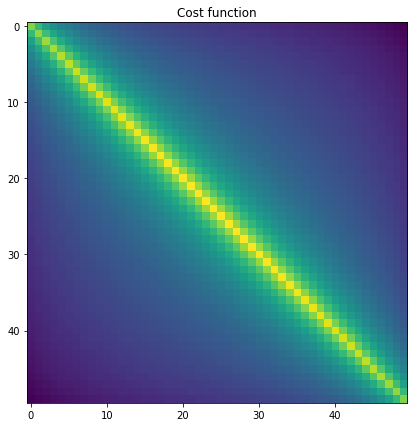

In [8]:
OT_network.plot_cost(C2[1])

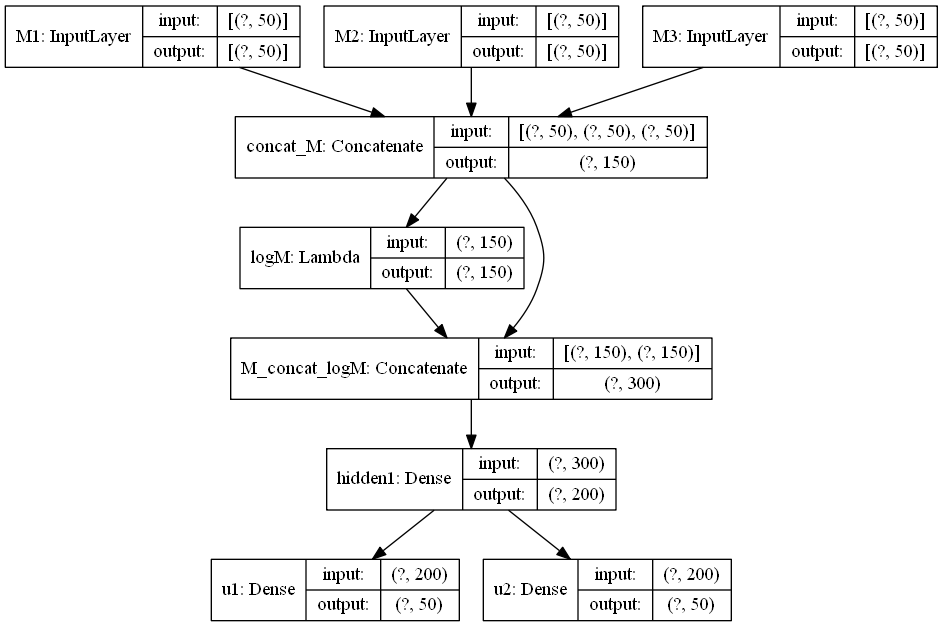

In [9]:
net = OT_network(C2[1], 0.01)
net.plot_model

In [10]:
potentials, P = net.fit([MU[0], MU[0], MU[0]], epochs=80)

  0%|                                                                                           | 0/80 [00:00<?, ?it/s]


AssertionError: Could not compute output Tensor("u1/Identity:0", shape=(None, 50), dtype=float32)

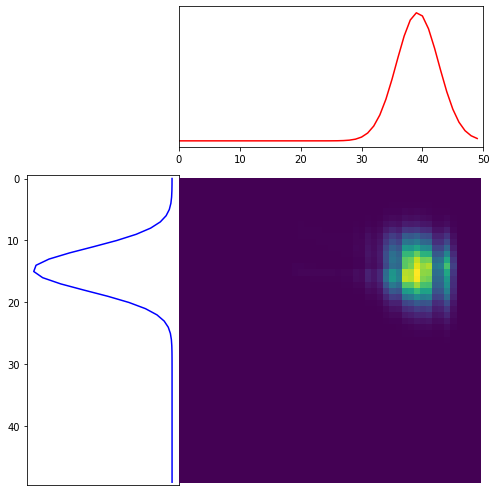

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.58it/s]


In [11]:
# simulaiton for dissociation (change of marginal)
for i in range(1,21):
    _potentials, _P = net.fit(np.array([np.stack([MU[0], MU[i], MU[0]])]), epochs=10)
#     fig = net.plot_P(MU[i], MU[20], _P[0])
#     fig.savefig(f"C2\\dnn\\Dispersion\\3AB-{20+i}.png")

iters: 21


<module 'matplotlib.pyplot' from 'C:\\Users\\manyasha_n_m\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

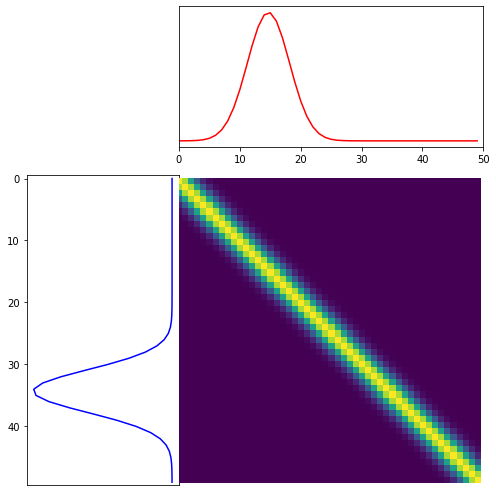

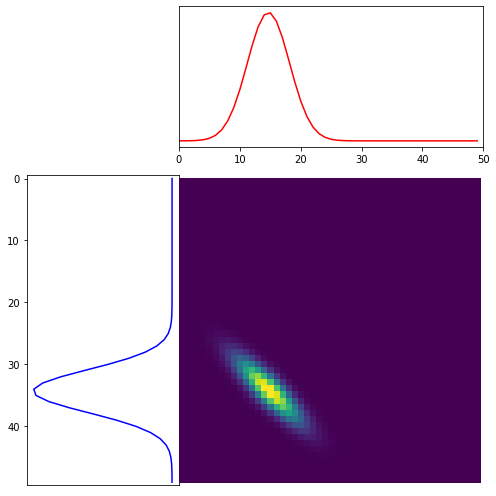

In [20]:
# sinkhorn for comparison
potentials_sink, P_sink = dual_sinkhorn([A, B], C1[0], 0.003, 0.001)
net.plot_P(A, B, P_sink)